In [1]:
from importlib import reload
#reload(Utilities)
#reload(clm)

import sys, os
import re

import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
from scipy import stats
import datetime
import time
from natsort import natsorted, ns

import pyodbc
#---------------------------------------------------------------------
sys.path.insert(0, os.path.realpath('..'))
import Utilities_config
#-----
import CommonLearningMethods as clm
#-----
from DOVSOutages_SQL import DOVSOutages_SQL
from DOVSOutages import DOVSOutages
#---------------------------------------------------------------------
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
#---------------------------------------------------------------------
sys.path.insert(0, Utilities_config.get_utilities_dir())
import Utilities
import Utilities_df
import Utilities_dt
from Utilities_df import DFConstructType
import Plot_General
import Plot_Box_sns
import GrubbsTest

In [2]:
def set_pct_col(df, col='SUM_CMI_NB', pct_col='pct_cmi_nb'): 
    df[pct_col] = 100*df[col]/df[col].sum()
    return df

In [3]:
def draw_outages_summary_barplot(fig, ax, df, 
                                 x_col='MJR_MNR_CAUSE_NM', y_col='pct_cmi_nb', 
                                 sort_values=True, y_threshold=None, abbr_leg_str=None, 
                                 include_labels='include', 
                                 x_tick_new_labels_dict=None, return_x_values_included=False, 
                                 **kwargs):
    # Current kwargs keys: 'palette_dict', 'xlabel' 'ylabel', 'x_tick_rotation', 'title', 'title_font_size'
    # y_threshold:
    #     if y_threshold is not None, it should be a dict with keys = ['threshold_col', 'threshold_val']
    #       e.g. y_threshold={'threshold_col':'pct_cmi_nb', 'threshold_val':1.0}
    # include_labels: 
    #     can equal 'include', 'exclude', 'passive' (CASE INSENSITIVE)
    include_labels = include_labels.lower()
    possible_include_labels = ['include', 'exclude', 'passive']
    if include_labels not in possible_include_labels:
        possible_include_labels = 'include'
    #---------------
    if y_threshold is not None:
        assert('threshold_col' in y_threshold and 'threshold_val' in y_threshold)
        df_to_plot = df[df[y_threshold['threshold_col']] > y_threshold['threshold_val']].copy()
    else:
        df_to_plot = df.copy()
    #---------------
    if sort_values:
        df_to_plot = df_to_plot.sort_values(by=y_col, ascending=False)
    #---------------
    sns.barplot(ax=ax, x=x_col, y=y_col, data=df_to_plot, 
                palette=kwargs.get('palette_dict', None))
    #---------------
    if include_labels=='include':
        ax.set_ylabel(kwargs.get('ylabel', y_col), fontsize=24, x=0.0, y=0.8, ha='left', va='bottom')
        ax.set_xlabel(kwargs.get('xlabel', x_col), fontsize=24, x=0.9, y=0.0, ha='right', va='top')   
        ax.tick_params(axis='both', labelsize=12)

        x_tick_rotation = kwargs.get('x_tick_rotation', 90)
        ax.tick_params(axis='x', labelrotation=x_tick_rotation, labelsize=12.0, direction='in')
        if x_tick_rotation != 0 and x_tick_rotation != 90:
            #-- Align rotated labels with ticks at end, not center
            for label in ax.xaxis.get_majorticklabels():
                label.set_horizontalalignment('right')

        if x_tick_new_labels_dict is not None:
            labels = [x.get_text() for x in ax.get_xticklabels()]
            new_labels = [x_tick_new_labels_dict[x] for x in labels]
            ax.set_xticklabels(new_labels)
    elif include_labels=='exclude':
        ax.set(xticklabels=[])
        ax.set(yticklabels=[])
        ax.set(xlabel=None)
        ax.set(ylabel=None)
    else:
        assert(include_labels=='passive')
    #---------------
    if abbr_leg_str is not None:
        ax.text(1.025, 0.9, abbr_leg_str, transform=ax.transAxes, fontsize=20, ha='left', va='top')
    ax.set_title(kwargs.get('title', None), fontsize=kwargs.get('title_font_size', 40))
    if return_x_values_included:
        return fig, ax, df_to_plot[x_col].unique().tolist()
    else:
        return fig,ax


In [4]:
conn_outages = Utilities.get_utldb01p_oracle_connection()
#conn_aws = Utilities.get_athena_prod_aws_connection()

In [5]:
fig_num = 0
save_figs = False
save_base_dir = r'C:\Users\s346557\Documents\Presentations\OutagePredictions\v0\Figures'

In [6]:
mjr_cause_nm_abbr_dict = {
    'DISTRIBUTION LINE':'DL', 
    'DISTRIBUTION STATION':'DSt', 
    'TRANSMISSION LINE':'TL', 
    'TRANSMISSION STATION':'TSt', 
    'PARTIAL POWER':'PP', 
    'DISTRIBUTION SOURCE':'DSrc', 
    'SUBTRANSMISSION LINE':'sTL', 
    'GENERATION':'G'    
}
max_len_abbr = len(max(list(mjr_cause_nm_abbr_dict.values()), key = len))
abbr_leg_str = ''
for mjr_cause in mjr_cause_nm_abbr_dict:
    abbr_leg_str += '{}: {}\n'.format(mjr_cause_nm_abbr_dict[mjr_cause].ljust(max_len_abbr), mjr_cause)

# BY MONTH

In [49]:
sql = (
"""
SELECT   EXTRACT(MONTH FROM DOV.DT_OFF_TS) AS MONTH_OFF_TS, SUM(DOV.CI_NB) AS SUM_CI_NB, SUM(DOV.CMI_NB) AS SUM_CMI_NB, COUNT(*)
        
FROM     DOVSADM.DOVS_OUTAGE_FACT DOV
         LEFT OUTER JOIN DOVSADM.DOVS_MASTER_GEO_DIM DOV1 ON DOV.OPERATING_UNIT_ID=DOV1.OPRTG_UNT_ID AND DOV.STATE_ABBR_TX = DOV1.STATE_ID   AND DOV.OPCO_NBR=DOV1.OPCO_ID AND DOV.DISTRICT_NB=DOV1.DISTRICT_ID AND DOV.SRVC_CNTR_NB=DOV1.AREA_ID AND DOV.GIS_CRCT_NB = DOV1.GIS_CIRCUIT_ID
         LEFT OUTER JOIN DOVSADM.DOVS_OUTAGE_ATTRIBUTES_DIM DOV2 ON DOV.OUTG_REC_NB=DOV2.OUTG_REC_NB 
         LEFT OUTER JOIN DOVSADM.DOVS_OUTAGE_CAUSE_TYPES_DIM DOV5 ON DOV.MJR_CAUSE_CD=DOV5.MJR_CAUSE_CD AND DOV.MNR_CAUSE_CD=DOV5.MNR_CAUSE_CD 

WHERE    DOV2.INTRPTN_TYP_CD = 'S' 
AND      DOV2.CURR_REC_STAT_CD = 'A'
AND      DOV.MJR_CAUSE_CD <> 'NI'
AND      DOV.DEVICE_CD <> 85
AND      DOV.JMED_FL = 'N'

GROUP BY EXTRACT(MONTH FROM DOV.DT_OFF_TS)
ORDER BY SUM(DOV.CMI_NB) DESC

"""
)

df_by_month = pd.read_sql(sql, conn_outages)

# df_by_opco = df_by_opco.groupby('OPRTG_UNT_NM', dropna=False, as_index=False, group_keys=False).apply(lambda x: set_pct_col(x, col='SUM_CMI_NB', pct_col='pct_cmi_nb'))
# df_by_opco = df_by_opco.groupby('OPRTG_UNT_NM', dropna=False, as_index=False, group_keys=False).apply(lambda x: set_pct_col(x, col='SUM_CI_NB', pct_col='pct_ci_nb'))
# df_by_opco = DOVSOutages.set_mjr_mnr_cause_nm_col(df_by_opco, set_null_to_NA=True, mjr_cause_nm_abbr_dict=mjr_cause_nm_abbr_dict)

C:\Temp/ipykernel_34508/2751239376.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_by_month = pd.read_sql(sql, conn_outages)


In [52]:
df_by_month

,MONTH_OFF_TS,SUM_CI_NB,SUM_CMI_NB,COUNT(*)
0,6.0,16103142.0,2.667251e+09,385158.0
1,7.0,13868725.0,2.394872e+09,331631.0
2,5.0,14772287.0,2.280427e+09,330089.0
3,8.0,12300918.0,1.858933e+09,290799.0
4,4.0,11618690.0,1.694762e+09,253326.0
5,3.0,10241673.0,1.505407e+09,224111.0
6,9.0,10239549.0,1.462784e+09,241351.0
7,2.0,8703212.0,1.409905e+09,191514.0
8,10.0,9970712.0,1.381413e+09,241103.0
9,1.0,9031724.0,1.336505e+09,200720.0


In [55]:
df_by_month = set_pct_col(df_by_month, col='SUM_CMI_NB', pct_col='pct_cmi_nb')
df_by_month = set_pct_col(df_by_month, col='SUM_CI_NB', pct_col='pct_ci_nb')

In [56]:
df_by_month

,MONTH_OFF_TS,SUM_CI_NB,SUM_CMI_NB,COUNT(*),pct_cmi_nb,pct_ci_nb
0,6.0,16103142.0,2.667251e+09,385158.0,12.998463,11.981522
1,7.0,13868725.0,2.394872e+09,331631.0,11.671060,10.319007
2,5.0,14772287.0,2.280427e+09,330089.0,11.113332,10.991301
3,8.0,12300918.0,1.858933e+09,290799.0,9.059241,9.152482
4,4.0,11618690.0,1.694762e+09,253326.0,8.259179,8.644871
5,3.0,10241673.0,1.505407e+09,224111.0,7.336381,7.620303
6,9.0,10239549.0,1.462784e+09,241351.0,7.128667,7.618723
7,2.0,8703212.0,1.409905e+09,191514.0,6.870966,6.475614
8,10.0,9970712.0,1.381413e+09,241103.0,6.732116,7.418695
9,1.0,9031724.0,1.336505e+09,200720.0,6.513262,6.720042


In [57]:
df_by_month.sort_values(by=['MONTH_OFF_TS'], ignore_index=True)

,MONTH_OFF_TS,SUM_CI_NB,SUM_CMI_NB,COUNT(*),pct_cmi_nb,pct_ci_nb
0,1.0,9031724.0,1.336505e+09,200720.0,6.513262,6.720042
1,2.0,8703212.0,1.409905e+09,191514.0,6.870966,6.475614
2,3.0,10241673.0,1.505407e+09,224111.0,7.336381,7.620303
3,4.0,11618690.0,1.694762e+09,253326.0,8.259179,8.644871
4,5.0,14772287.0,2.280427e+09,330089.0,11.113332,10.991301
5,6.0,16103142.0,2.667251e+09,385158.0,12.998463,11.981522
6,7.0,13868725.0,2.394872e+09,331631.0,11.671060,10.319007
7,8.0,12300918.0,1.858933e+09,290799.0,9.059241,9.152482
8,9.0,10239549.0,1.462784e+09,241351.0,7.128667,7.618723
9,10.0,9970712.0,1.381413e+09,241103.0,6.732116,7.418695


<Axes: xlabel='MONTH_OFF_TS', ylabel='pct_cmi_nb'>

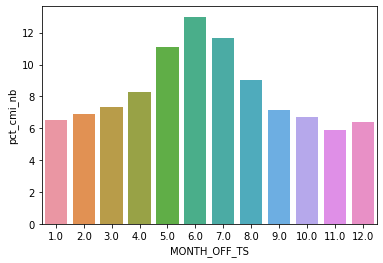

In [58]:
sns.barplot(x='MONTH_OFF_TS', y='pct_cmi_nb', data=df_by_month)

<Axes: xlabel='MONTH_OFF_TS', ylabel='pct_ci_nb'>

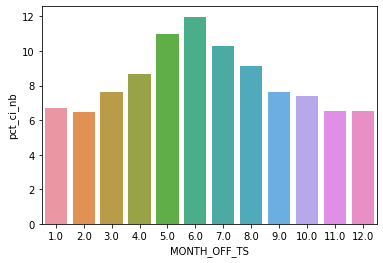

In [59]:
sns.barplot(x='MONTH_OFF_TS', y='pct_ci_nb', data=df_by_month)

<Axes: xlabel='MONTH_OFF_TS', ylabel='COUNT(*)'>

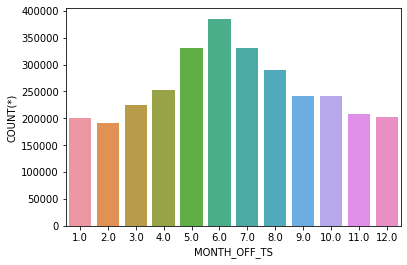

In [60]:
sns.barplot(x='MONTH_OFF_TS', y='COUNT(*)', data=df_by_month)

# BY OPCO, CAUSE, and MONTH

In [47]:
#GROUP BY OP UNIT AS WELL

sql = (
"""
SELECT   DOV.MJR_CAUSE_CD, DOV.MNR_CAUSE_CD, SUM(DOV.CI_NB) AS SUM_CI_NB, SUM(DOV.CMI_NB) AS SUM_CMI_NB, DOV.OPERATING_UNIT_ID, DOV1.OPRTG_UNT_NM, DOV5.MJR_CAUSE_NM, DOV5.MNR_CAUSE_NM, EXTRACT(MONTH FROM DOV.DT_OFF_TS) AS MONTH_OFF_TS
        
FROM     DOVSADM.DOVS_OUTAGE_FACT DOV
         LEFT OUTER JOIN DOVSADM.DOVS_MASTER_GEO_DIM DOV1 ON DOV.OPERATING_UNIT_ID=DOV1.OPRTG_UNT_ID AND DOV.STATE_ABBR_TX = DOV1.STATE_ID   AND DOV.OPCO_NBR=DOV1.OPCO_ID AND DOV.DISTRICT_NB=DOV1.DISTRICT_ID AND DOV.SRVC_CNTR_NB=DOV1.AREA_ID AND DOV.GIS_CRCT_NB = DOV1.GIS_CIRCUIT_ID
         LEFT OUTER JOIN DOVSADM.DOVS_OUTAGE_ATTRIBUTES_DIM DOV2 ON DOV.OUTG_REC_NB=DOV2.OUTG_REC_NB 
         LEFT OUTER JOIN DOVSADM.DOVS_OUTAGE_CAUSE_TYPES_DIM DOV5 ON DOV.MJR_CAUSE_CD=DOV5.MJR_CAUSE_CD AND DOV.MNR_CAUSE_CD=DOV5.MNR_CAUSE_CD 

WHERE    DOV2.INTRPTN_TYP_CD = 'S' 
AND      DOV2.CURR_REC_STAT_CD = 'A'
AND      DOV.MJR_CAUSE_CD <> 'NI'
AND      DOV.DEVICE_CD <> 85
AND      DOV.JMED_FL = 'N'

GROUP BY DOV.MJR_CAUSE_CD, DOV.MNR_CAUSE_CD, DOV5.MJR_CAUSE_NM, DOV5.MNR_CAUSE_NM, DOV1.OPRTG_UNT_NM, DOV.OPERATING_UNIT_ID, EXTRACT(MONTH FROM DOV.DT_OFF_TS)
ORDER BY SUM(DOV.CMI_NB) DESC

"""
)

df_by_opco = pd.read_sql(sql, conn_outages)

# df_by_opco = df_by_opco.groupby('OPRTG_UNT_NM', dropna=False, as_index=False, group_keys=False).apply(lambda x: set_pct_col(x, col='SUM_CMI_NB', pct_col='pct_cmi_nb'))
# df_by_opco = df_by_opco.groupby('OPRTG_UNT_NM', dropna=False, as_index=False, group_keys=False).apply(lambda x: set_pct_col(x, col='SUM_CI_NB', pct_col='pct_ci_nb'))
# df_by_opco = DOVSOutages.set_mjr_mnr_cause_nm_col(df_by_opco, set_null_to_NA=True, mjr_cause_nm_abbr_dict=mjr_cause_nm_abbr_dict)

C:\Temp/ipykernel_34508/4039649010.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_by_opco = pd.read_sql(sql, conn_outages)


In [48]:
df_by_opco

,MJR_CAUSE_CD,MNR_CAUSE_CD,SUM_CI_NB,SUM_CMI_NB,OPERATING_UNIT_ID,OPRTG_UNT_NM,MJR_CAUSE_NM,MNR_CAUSE_NM,EXTRACT(MONTHFROMDOV.DT_OFF_TS)
0,DL,TOR,1018756.0,362434534.0,1,AEP-Appalachian Power,DISTRIBUTION LINE,TREE OUT OF ROW,7.0
1,DL,TOR,1049072.0,350335433.0,1,AEP-Appalachian Power,DISTRIBUTION LINE,TREE OUT OF ROW,6.0
2,DL,TOR,961617.0,305218637.0,1,AEP-Appalachian Power,DISTRIBUTION LINE,TREE OUT OF ROW,5.0
3,DL,TOR,699646.0,215400168.0,1,AEP-Appalachian Power,DISTRIBUTION LINE,TREE OUT OF ROW,8.0
4,DL,TOR,570735.0,190583223.0,1,AEP-Appalachian Power,DISTRIBUTION LINE,TREE OUT OF ROW,2.0
...,...,...,...,...,...,...,...,...,...
8336,DS,O,2.0,18.0,5,AEP-Public Service Co of OK,DISTRIBUTION STATION,OTHER,9.0
8337,PP,UB,1.0,17.0,5,AEP-Public Service Co of OK,PARTIAL POWER,UNBALANCE,12.0
8338,PP,OL,1.0,15.0,1,AEP-Appalachian Power,PARTIAL POWER,OVERLOAD,8.0
8339,DS,FW,1.0,11.0,3,AEP-Ohio,DISTRIBUTION STATION,FACILITATION OF WORK,2.0


In [9]:
df_by_opco

,MJR_CAUSE_CD,MNR_CAUSE_CD,SUM_CI_NB,SUM_CMI_NB,OPERATING_UNIT_ID,OPRTG_UNT_NM,MJR_CAUSE_NM,MNR_CAUSE_NM,pct_cmi_nb,pct_ci_nb,MJR_MNR_CAUSE_NM
0,DL,TOR,7660090.0,2.460880e+09,1,AEP-Appalachian Power,DISTRIBUTION LINE,TREE OUT OF ROW,3.284016e+01,22.371131,DL-TREE OUT OF ROW
1,DL,EQF,7384036.0,1.277614e+09,1,AEP-Appalachian Power,DISTRIBUTION LINE,EQUIPMENT FAILURE,1.704961e+01,21.564921,DL-EQUIPMENT FAILURE
2,DL,EQF,7310992.0,9.303329e+08,3,AEP-Ohio,DISTRIBUTION LINE,EQUIPMENT FAILURE,2.044622e+01,23.177585,DL-EQUIPMENT FAILURE
3,DL,TOR,3988223.0,8.972992e+08,3,AEP-Ohio,DISTRIBUTION LINE,TREE OUT OF ROW,1.972023e+01,12.643616,DL-TREE OUT OF ROW
4,DL,TIR,3043426.0,8.285474e+08,1,AEP-Appalachian Power,DISTRIBUTION LINE,TREE INSIDE ROW,1.105687e+01,8.888261,DL-TREE INSIDE ROW
...,...,...,...,...,...,...,...,...,...,...,...
1150,DS,SO,1.0,6.000000e+01,5,AEP-Public Service Co of OK,DISTRIBUTION STATION,SCHEDULED OUTSIDE REQUEST > 1 CUSTOMER,6.116514e-06,0.000010,DSt-SCHEDULED OUTSIDE REQUEST > 1 CUSTOMER
1151,TL,UB,1.0,5.600000e+01,7,AEP-Texas,TRANSMISSION LINE,UNBALANCE,2.234091e-06,0.000004,TL-UNBALANCE
1152,PP,F,1.0,4.200000e+01,5,AEP-Public Service Co of OK,PARTIAL POWER,"FIRE-AEP, OR AFFECTING > 1 CUSTOMER",4.281560e-06,0.000010,"PP-FIRE-AEP, OR AFFECTING > 1 CUSTOMER"
1153,DS,OV,1.0,2.500000e+01,7,AEP-Texas,DISTRIBUTION STATION,OVERVOLTAGE,9.973623e-07,0.000004,DSt-OVERVOLTAGE


### Get df_by_cause from df_by_opco

In [ ]:
cols_to_drop = ['OPERATING_UNIT_ID', 'OPRTG_UNT_NM']
cols_to_agg = ['SUM_CI_NB', 'SUM_CMI_NB', 'pct_cmi_nb', 'pct_ci_nb']
cols_to_groupby = [x for x in df_by_opco.columns 
                   if x not in (cols_to_drop+cols_to_agg)]
#-----
df_by_cause_from_by_opco = df_by_opco.drop(columns=cols_to_drop).groupby(cols_to_groupby, dropna=False).agg({x:'sum' for x in cols_to_agg})
df_by_cause_from_by_opco = df_by_cause_from_by_opco.reset_index() #flatten out index, instead of multi-index of groups
df_by_cause_from_by_opco = set_pct_col(df_by_cause_from_by_opco, col='SUM_CMI_NB', pct_col='pct_cmi_nb')
df_by_cause_from_by_opco = set_pct_col(df_by_cause_from_by_opco, col='SUM_CI_NB', pct_col='pct_ci_nb')
df_by_cause_from_by_opco = df_by_cause_from_by_opco.sort_values(by='pct_cmi_nb', ignore_index=True, ascending=False)

In [ ]:
# Build x_tick_new_labels_dict for all possible values of 'MJR_MNR_CAUSE_NM'
# where the new labels are simply to ordering of the causes when sorted by pct_cmi_nb
x_tick_new_labels_dict = df_by_cause_from_by_opco.sort_values(by='pct_cmi_nb', ascending=False)['MJR_MNR_CAUSE_NM'].to_dict()
x_tick_new_labels_dict = {v:k+1 for k,v in x_tick_new_labels_dict.items()}

# Build palette_dict for those values of 'MJR_MNR_CAUSE_NM' which will actually be plotted
pct_cutoff = 1.0
top_mjr_mnr_causes_cmi = df_by_opco[df_by_opco['pct_cmi_nb']>pct_cutoff]['MJR_MNR_CAUSE_NM'].unique().tolist()
top_mjr_mnr_causes_ci = df_by_opco[df_by_opco['pct_ci_nb']>pct_cutoff]['MJR_MNR_CAUSE_NM'].unique().tolist()
top_mjr_mnr_causes = top_mjr_mnr_causes_cmi.copy()
top_mjr_mnr_causes.extend([x for x in top_mjr_mnr_causes_ci if x not in top_mjr_mnr_causes])
palette_dict = Plot_General.get_standard_colors_dict(top_mjr_mnr_causes)

In [ ]:
df_by_cause_from_by_opco

In [ ]:
fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
fig, ax = draw_outages_summary_barplot(fig, ax, df_by_cause_from_by_opco, 
                                       x_col='MJR_MNR_CAUSE_NM', y_col='pct_cmi_nb', 
                                       y_threshold={'threshold_col':'pct_cmi_nb', 'threshold_val':pct_cutoff}, 
                                       ylabel='% CMI', xlabel='Major-Minor Cause', title='Outage CMI by Cause', 
                                       x_tick_rotation=90, palette_dict=palette_dict)
fig_num += 1 

In [ ]:
# for opco_name, df in df_by_opco.groupby('OPRTG_UNT_NM', dropna=False):
#     fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
#     fig, ax = draw_outages_summary_barplot(fig, ax, df, 
#                                            x_col='MJR_MNR_CAUSE_NM', y_col='pct_cmi_nb', 
#                                            y_threshold={'threshold_col':'pct_cmi_nb', 'threshold_val':pct_cutoff}, 
#                                            ylabel='% CMI', xlabel='Major-Minor Cause', title=f'OPCO: {opco_name}', 
#                                            x_tick_rotation=90, palette_dict=palette_dict, abbr_leg_str=abbr_leg_str)
#     fig_num += 1    

In [ ]:
assert(len(df_by_opco['OPRTG_UNT_NM'].unique())==8)
plots_ny = 2
plots_nx = 4
fig, axs = plt.subplots(plots_ny, plots_nx, num=fig_num, figsize=[25, 11])
all_x_vals_included = []
for i, (opco_name, df) in enumerate(df_by_opco.groupby('OPRTG_UNT_NM', dropna=False)):
    i_y, i_x = divmod(i, plots_nx)
    ax = axs[i_y, i_x]
    fig, ax, x_vals_included = draw_outages_summary_barplot(fig, ax, df, 
                                                            x_col='MJR_MNR_CAUSE_NM', y_col='pct_cmi_nb', 
                                                            y_threshold={'threshold_col':'pct_cmi_nb', 'threshold_val':pct_cutoff}, 
                                                            ylabel=None, xlabel=None, x_tick_rotation=0, 
                                                            title=f'{opco_name}', title_font_size=20, 
                                                            x_tick_new_labels_dict=x_tick_new_labels_dict, return_x_values_included=True, 
                                                            palette_dict=palette_dict)
    all_x_vals_included = list(set(all_x_vals_included + x_vals_included))
    
subplot_key_elements = [(x_tick_new_labels_dict[x_val], x_val) for x_val in all_x_vals_included]
subplot_key_elements = sorted(subplot_key_elements, key = lambda tup: tup[0])


top = 0.875 #mpl.rcParams["figure.subplot.top"]
bottom = 0.125 #mpl.rcParams["figure.subplot.bottom"]
left = 0.05
right = 0.75
plt.subplots_adjust(wspace=0.2, left=left, right=right, top=top, bottom=bottom)
fig.suptitle('Outage CMI by OPCO and Cause', fontsize=40, x=0.5*(left+right), ha='center')

fig.supxlabel('Cause', fontsize=30, 
              x=right, ha='right', 
              y=0.0, va='bottom')
fig.supylabel('% CMI', fontsize=30, 
              x=0.0, ha='left',
              y=top, va='top')

n_chars_per_line = 30
subplot_key_text = ''
for tup in subplot_key_elements:
    n_lines = int(np.ceil(len(tup[1])/n_chars_per_line))
    for i_line in range(n_lines):
        if i_line==0:
            subplot_key_text += '{}: {}{}\n'.format(tup[0], tup[1][i_line*n_chars_per_line: (i_line+1)*n_chars_per_line], 
                                                    '-' if n_lines>1 else '')
        else:
            # NOTE: Extending upper limit of slice above total number is fine, it will stop at end of array
            subplot_key_text += '       {}\n'.format(tup[1][i_line*n_chars_per_line: (i_line+1)*n_chars_per_line])

fig.text(1.02*right, top, subplot_key_text, fontsize=18, ha='left', va='top')
if save_figs:
    fig.savefig(os.path.join(save_base_dir, 'Outage_CMI_by_OPCO_and_Cause.png'))
fig_num += 1    

In [ ]:
# fig.savefig(r'C:\Users\s346557\Documents\test.png')

### Get df_by_opco_only from df_by_opco

In [ ]:
cols_to_drop = ['MJR_CAUSE_CD', 'MNR_CAUSE_CD', 'MJR_CAUSE_NM', 'MNR_CAUSE_NM', 'MJR_MNR_CAUSE_NM']
cols_to_agg = ['SUM_CI_NB', 'SUM_CMI_NB', 'pct_cmi_nb', 'pct_ci_nb']
cols_to_groupby = [x for x in df_by_opco.columns 
                   if x not in (cols_to_drop+cols_to_agg)]
#-----
df_by_opco_only_1 = df_by_opco.drop(columns=cols_to_drop).groupby(cols_to_groupby, dropna=False).agg({x:'sum' for x in cols_to_agg})
df_by_opco_only_1 = df_by_opco_only_1.reset_index() #flatten out index, instead of multi-index of groups
df_by_opco_only_1 = set_pct_col(df_by_opco_only_1, col='SUM_CMI_NB', pct_col='pct_cmi_nb')
df_by_opco_only_1 = set_pct_col(df_by_opco_only_1, col='SUM_CI_NB', pct_col='pct_ci_nb')
df_by_opco_only_1 = df_by_opco_only_1.sort_values(by='pct_cmi_nb', ignore_index=True, ascending=False)
#---------------------------------
fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
fig, ax = draw_outages_summary_barplot(fig, ax, df_by_opco_only_1, 
                                       x_col='OPRTG_UNT_NM', y_col='pct_cmi_nb', 
                                       ylabel='% CMI', xlabel='Operating Unit', title='Outage CMI by OPCO', 
                                       x_tick_rotation=90)
fig_num += 1 
#---------------------------------
fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
fig, ax = draw_outages_summary_barplot(fig, ax, df_by_opco_only_1, 
                                       x_col='OPRTG_UNT_NM', y_col='pct_ci_nb', 
                                       ylabel='% CI', xlabel='Operating Unit', title='Outage CI by OPCO', 
                                       x_tick_rotation=90)
fig_num += 1 

# OPCO ONLY

In [ ]:
#GROUP BY OP UNIT AS WELL

sql = (
"""
SELECT   SUM(DOV.CI_NB) AS SUM_CI_NB, SUM(DOV.CMI_NB) AS SUM_CMI_NB, DOV.OPERATING_UNIT_ID, DOV1.OPRTG_UNT_NM
        
FROM     DOVSADM.DOVS_OUTAGE_FACT DOV
         LEFT OUTER JOIN DOVSADM.DOVS_MASTER_GEO_DIM DOV1 ON DOV.OPERATING_UNIT_ID=DOV1.OPRTG_UNT_ID AND DOV.STATE_ABBR_TX = DOV1.STATE_ID   AND DOV.OPCO_NBR=DOV1.OPCO_ID AND DOV.DISTRICT_NB=DOV1.DISTRICT_ID AND DOV.SRVC_CNTR_NB=DOV1.AREA_ID AND DOV.GIS_CRCT_NB = DOV1.GIS_CIRCUIT_ID
         LEFT OUTER JOIN DOVSADM.DOVS_OUTAGE_ATTRIBUTES_DIM DOV2 ON DOV.OUTG_REC_NB=DOV2.OUTG_REC_NB 
         LEFT OUTER JOIN DOVSADM.DOVS_OUTAGE_CAUSE_TYPES_DIM DOV5 ON DOV.MJR_CAUSE_CD=DOV5.MJR_CAUSE_CD AND DOV.MNR_CAUSE_CD=DOV5.MNR_CAUSE_CD 

WHERE    DOV2.INTRPTN_TYP_CD = 'S' 
AND      DOV2.CURR_REC_STAT_CD = 'A'
AND      DOV.MJR_CAUSE_CD <> 'NI'
AND      DOV.DEVICE_CD <> 85
AND      DOV.JMED_FL = 'N'

GROUP BY DOV1.OPRTG_UNT_NM, DOV.OPERATING_UNIT_ID
ORDER BY SUM(DOV.CMI_NB) DESC

"""
)
print(sql)

df_by_opco_only = pd.read_sql(sql, conn_outages)

df_by_opco_only = set_pct_col(df_by_opco_only, col='SUM_CMI_NB', pct_col='pct_cmi_nb')
df_by_opco_only = set_pct_col(df_by_opco_only, col='SUM_CI_NB', pct_col='pct_ci_nb')

In [ ]:
df_by_opco_only

In [ ]:
# fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
# fig, ax = draw_outages_summary_barplot(fig, ax, df_by_opco_only, 
#                                        x_col='OPRTG_UNT_NM', y_col='pct_cmi_nb', 
#                                        ylabel='% CMI', xlabel='Operating Unit', title='Outage CMI by OPCO', 
#                                        x_tick_rotation=90)
# fig_num += 1 
# #---------------------------------------------------------------------------
# fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
# fig, ax = draw_outages_summary_barplot(fig, ax, df_by_opco_only, 
#                                        x_col='OPRTG_UNT_NM', y_col='pct_ci_nb', 
#                                        ylabel='% CI', xlabel='Operating Unit', title='Outage CI by OPCO', 
#                                        x_tick_rotation=90)
# fig_num += 1 

In [ ]:
top = mpl.rcParams["figure.subplot.top"]
bottom = 0.25 #mpl.rcParams["figure.subplot.bottom"]
left = 0.075
right = 0.95
fig, axs = plt.subplots(1, 2, num=fig_num, figsize=[22, 8.5])
plt.subplots_adjust(wspace=0.2, left=left, right=right, top=top, bottom=bottom)

fig, axs[0] = draw_outages_summary_barplot(fig, axs[0], df_by_opco_only, 
                                       x_col='OPRTG_UNT_NM', y_col='pct_cmi_nb', 
                                       ylabel='% CMI', xlabel='Operating Unit', title='Outage CMI by OPCO', 
                                       x_tick_rotation=45)
#---------------------------------------------------------------------------
fig, axs[1] = draw_outages_summary_barplot(fig, axs[1], df_by_opco_only, 
                                       x_col='OPRTG_UNT_NM', y_col='pct_ci_nb', 
                                       ylabel='% CI', xlabel='Operating Unit', title='Outage CI by OPCO', 
                                       x_tick_rotation=45)
if save_figs:
    fig.savefig(os.path.join(save_base_dir, 'Outage_CMI_and_CI_by_OPCO.png'))
fig_num += 1 

# BY CAUSE ONLY

In [ ]:
# These two queries yield the same results, since there is 1-1 relationship between 
# DOV5.MJR_CAUSE_NM--DOV5.MJR_CAUSE_CD and DOV5.MNR_CAUSE_NM--DOV5.MNR_CAUSE_CD
# The first I guess is more careful, in case this 1-1 relationship did not work
# But the second is shorter and simpler

# sql = (
# """
# WITH DOV AS (
#     SELECT   DOV.MJR_CAUSE_CD, DOV.MNR_CAUSE_CD, SUM(DOV.CI_NB) AS SUM_CI_NB, SUM(DOV.CMI_NB) AS SUM_CMI_NB

#     FROM     DOVSADM.DOVS_OUTAGE_FACT DOV
#              LEFT OUTER JOIN DOVSADM.DOVS_MASTER_GEO_DIM DOV1 ON DOV.OPERATING_UNIT_ID=DOV1.OPRTG_UNT_ID AND DOV.STATE_ABBR_TX = DOV1.STATE_ID   AND DOV.OPCO_NBR=DOV1.OPCO_ID AND DOV.DISTRICT_NB=DOV1.DISTRICT_ID AND DOV.SRVC_CNTR_NB=DOV1.AREA_ID AND DOV.GIS_CRCT_NB = DOV1.GIS_CIRCUIT_ID
#              LEFT OUTER JOIN DOVSADM.DOVS_OUTAGE_ATTRIBUTES_DIM DOV2 ON DOV.OUTG_REC_NB=DOV2.OUTG_REC_NB 
#              LEFT OUTER JOIN DOVSADM.DOVS_OUTAGE_CAUSE_TYPES_DIM DOV5 ON DOV.MJR_CAUSE_CD=DOV5.MJR_CAUSE_CD AND DOV.MNR_CAUSE_CD=DOV5.MNR_CAUSE_CD 
#     WHERE    DOV2.INTRPTN_TYP_CD = 'S' 
#     AND      DOV2.CURR_REC_STAT_CD = 'A'
#     AND      DOV.MJR_CAUSE_CD <> 'NI'
#     AND      DOV.DEVICE_CD <> 85
#     AND      DOV.DT_OFF_TS BETWEEN '2020-01-01' AND '2021-03-31'
#     AND      DOV.JMED_FL = 'N'

#     GROUP BY DOV.MJR_CAUSE_CD, DOV.MNR_CAUSE_CD

# )
# SELECT DOV.MJR_CAUSE_CD, DOV.MNR_CAUSE_CD, DOV.SUM_CI_NB, DOV.SUM_CMI_NB, DOV5.MJR_CAUSE_NM, DOV5.MNR_CAUSE_NM
# FROM DOV
# LEFT OUTER JOIN DOVSADM.DOVS_OUTAGE_CAUSE_TYPES_DIM DOV5 
# ON DOV.MJR_CAUSE_CD=DOV5.MJR_CAUSE_CD AND DOV.MNR_CAUSE_CD=DOV5.MNR_CAUSE_CD 
# ORDER BY DOV.SUM_CMI_NB DESC
# """
# )

sql = (
"""
SELECT   DOV.MJR_CAUSE_CD, DOV.MNR_CAUSE_CD, SUM(DOV.CI_NB) AS SUM_CI_NB, SUM(DOV.CMI_NB) AS SUM_CMI_NB, DOV5.MJR_CAUSE_NM, DOV5.MNR_CAUSE_NM
        
FROM     DOVSADM.DOVS_OUTAGE_FACT DOV
         LEFT OUTER JOIN DOVSADM.DOVS_MASTER_GEO_DIM DOV1 ON DOV.OPERATING_UNIT_ID=DOV1.OPRTG_UNT_ID AND DOV.STATE_ABBR_TX = DOV1.STATE_ID   AND DOV.OPCO_NBR=DOV1.OPCO_ID AND DOV.DISTRICT_NB=DOV1.DISTRICT_ID AND DOV.SRVC_CNTR_NB=DOV1.AREA_ID AND DOV.GIS_CRCT_NB = DOV1.GIS_CIRCUIT_ID
         LEFT OUTER JOIN DOVSADM.DOVS_OUTAGE_ATTRIBUTES_DIM DOV2 ON DOV.OUTG_REC_NB=DOV2.OUTG_REC_NB 
         LEFT OUTER JOIN DOVSADM.DOVS_OUTAGE_CAUSE_TYPES_DIM DOV5 ON DOV.MJR_CAUSE_CD=DOV5.MJR_CAUSE_CD AND DOV.MNR_CAUSE_CD=DOV5.MNR_CAUSE_CD 
WHERE    DOV2.INTRPTN_TYP_CD = 'S' 
AND      DOV2.CURR_REC_STAT_CD = 'A'
AND      DOV.MJR_CAUSE_CD <> 'NI'
AND      DOV.DEVICE_CD <> 85
AND      DOV.JMED_FL = 'N'

GROUP BY DOV.MJR_CAUSE_CD, DOV.MNR_CAUSE_CD, DOV5.MJR_CAUSE_NM, DOV5.MNR_CAUSE_NM
ORDER BY SUM(DOV.CMI_NB) DESC
"""
)

df_by_cause = pd.read_sql(sql, conn_outages)

In [ ]:
df_by_cause = set_pct_col(df_by_cause, col='SUM_CMI_NB', pct_col='pct_cmi_nb')
df_by_cause = set_pct_col(df_by_cause, col='SUM_CI_NB', pct_col='pct_ci_nb')
df_by_cause = DOVSOutages.set_mjr_mnr_cause_nm_col(df_by_cause, set_null_to_NA=True, mjr_cause_nm_abbr_dict=mjr_cause_nm_abbr_dict)

In [ ]:
#df_by_cause.head(10)

In [ ]:
pct_cutoff = 1.0
top_mjr_mnr_causes_cmi = df_by_cause[df_by_cause['pct_cmi_nb']>pct_cutoff]['MJR_MNR_CAUSE_NM'].unique().tolist()
top_mjr_mnr_causes_ci = df_by_cause[df_by_cause['pct_ci_nb']>pct_cutoff]['MJR_MNR_CAUSE_NM'].unique().tolist()
top_mjr_mnr_causes = top_mjr_mnr_causes_cmi.copy()
top_mjr_mnr_causes.extend([x for x in top_mjr_mnr_causes_ci if x not in top_mjr_mnr_causes])

# Add any additional top_mjr_mnr_causes, trying to maintain original
# color scheme as much as possible...
if any([x in palette_dict for x in top_mjr_mnr_causes]):
    for x in top_mjr_mnr_causes:
        if x not in palette_dict:
            palette_dict[x] = None
    palette_dict = Plot_General.get_standard_colors_dict(list(palette_dict.keys()))

In [ ]:
top = mpl.rcParams["figure.subplot.top"]
bottom = 0.45 #mpl.rcParams["figure.subplot.bottom"]
left = 0.075
right = 0.75
fig, axs = plt.subplots(1, 2, num=fig_num, figsize=[22, 8.5])
plt.subplots_adjust(wspace=0.2, left=left, right=right, top=top, bottom=bottom)

fig, axs[0] = draw_outages_summary_barplot(fig, axs[0], df_by_cause, 
                                       y_threshold={'threshold_col':'pct_cmi_nb', 'threshold_val':pct_cutoff}, 
                                       ylabel='% CMI', xlabel=None, title='Outage CMI by Cause', 
                                       palette_dict=palette_dict, x_tick_rotation=45)
#---------------------------------------------------------------------------
fig, axs[1] = draw_outages_summary_barplot(fig, axs[1], df_by_cause, 
                                       x_col='MJR_MNR_CAUSE_NM', y_col='pct_ci_nb', 
                                       y_threshold={'threshold_col':'pct_ci_nb', 'threshold_val':pct_cutoff}, 
                                       ylabel='% CI', xlabel=None, title='Outage CI by Cause', 
                                       palette_dict=palette_dict, x_tick_rotation=45)
#---------------------------------------------------------------------------
fig.text(1.02*right, top, abbr_leg_str, fontsize=20, ha='left', va='top')
fig.supxlabel('Major-Minor Cause', fontsize=30, 
              x=right, ha='right', 
              y=0.0, va='bottom')
if save_figs:
    fig.savefig(os.path.join(save_base_dir, 'Outage_CMI_and_CI_by_Cause.png'))
fig_num += 1 

### Compare df_by_cause df_by_cause_from_by_opco

In [ ]:
df_by_cause_from_by_opco = df_by_cause_from_by_opco.sort_values(by='pct_cmi_nb', ignore_index=True, ascending=False)
diffs_df = Utilities_df.get_dfs_diff_approx_ok(df_by_cause, df_by_cause_from_by_opco[df_by_cause.columns], precision=0.01)
diffs_df

# Equipment Types

In [ ]:
sql = (
"""
SELECT   DOV4.EQUIP_TYP_NM, DOV4.SHORT_NM, SUM(DOV.CI_NB) AS SUM_CI_NB, SUM(DOV.CMI_NB) AS SUM_CMI_NB
        
FROM     DOVSADM.DOVS_OUTAGE_FACT DOV
         LEFT OUTER JOIN DOVSADM.DOVS_MASTER_GEO_DIM DOV1 ON DOV.OPERATING_UNIT_ID=DOV1.OPRTG_UNT_ID AND DOV.STATE_ABBR_TX = DOV1.STATE_ID   AND DOV.OPCO_NBR=DOV1.OPCO_ID AND DOV.DISTRICT_NB=DOV1.DISTRICT_ID AND DOV.SRVC_CNTR_NB=DOV1.AREA_ID AND DOV.GIS_CRCT_NB = DOV1.GIS_CIRCUIT_ID
         LEFT OUTER JOIN DOVSADM.DOVS_OUTAGE_ATTRIBUTES_DIM DOV2 ON DOV.OUTG_REC_NB=DOV2.OUTG_REC_NB 
         LEFT OUTER JOIN DOVSADM.DOVS_CLEARING_DEVICE_DIM DOV3 ON DOV.DEVICE_CD=DOV3.DEVICE_CD
         LEFT OUTER JOIN DOVSADM.DOVS_EQUIPMENT_TYPES_DIM DOV4 ON DOV.EQUIPMENT_CD=DOV4.EQUIPMENT_CD
         LEFT OUTER JOIN DOVSADM.DOVS_OUTAGE_CAUSE_TYPES_DIM DOV5 ON DOV.MJR_CAUSE_CD=DOV5.MJR_CAUSE_CD AND DOV.MNR_CAUSE_CD=DOV5.MNR_CAUSE_CD 
WHERE    DOV.MJR_CAUSE_CD = 'DL'
AND      DOV.MNR_CAUSE_CD = 'EQF'
AND      DOV2.INTRPTN_TYP_CD = 'S' 
AND      DOV2.CURR_REC_STAT_CD = 'A'
AND      DOV.MJR_CAUSE_CD <> 'NI'
AND      DOV.DEVICE_CD <> 85
AND      DOV.JMED_FL = 'N'

GROUP BY DOV4.EQUIP_TYP_NM, DOV4.SHORT_NM
ORDER BY SUM(DOV.CMI_NB) DESC
"""
)
print(sql)
df_eqp = pd.read_sql(sql, conn_outages)

In [ ]:
df_eqp = set_pct_col(df_eqp, col='SUM_CMI_NB', pct_col='pct_cmi_nb')
df_eqp = set_pct_col(df_eqp, col='SUM_CI_NB', pct_col='pct_ci_nb')

In [ ]:
top = mpl.rcParams["figure.subplot.top"]
bottom = 0.25 #mpl.rcParams["figure.subplot.bottom"]
left = 0.075
right = 0.95
fig, axs = plt.subplots(1, 2, num=fig_num, figsize=[22, 8.5])
plt.subplots_adjust(wspace=0.2, left=left, right=right, top=top, bottom=bottom)

fig, axs[0] = draw_outages_summary_barplot(fig, axs[0], df_eqp, 
                                       x_col='EQUIP_TYP_NM', y_col='pct_cmi_nb', 
                                       y_threshold={'threshold_col':'pct_cmi_nb', 'threshold_val':pct_cutoff}, 
                                       ylabel='% CMI', xlabel=None, 
                                       title='Outage CMI by Equip. Type (for DL-EQF)', title_font_size=30, 
                                       x_tick_rotation=45)
#---------------------------------------------------------------------------
fig, axs[1] = draw_outages_summary_barplot(fig, axs[1], df_eqp, 
                                       x_col='EQUIP_TYP_NM', y_col='pct_ci_nb', 
                                       y_threshold={'threshold_col':'pct_ci_nb', 'threshold_val':pct_cutoff}, 
                                       ylabel='% CI', xlabel=None, 
                                       title='Outage CI by Equip. Type (for DL-EQF)', title_font_size=30, 
                                       x_tick_rotation=45)
#---------------------------------------------------------------------------
fig.supxlabel('Equipment Type', fontsize=30, 
              x=right, ha='right', 
              y=0.0, va='bottom')
if save_figs:
    fig.savefig(os.path.join(save_base_dir, 'Outage_CMI_by_Eqp_Type.png'))
fig_num += 1 

In [ ]:
top = mpl.rcParams["figure.subplot.top"]
bottom = 0.25 #mpl.rcParams["figure.subplot.bottom"]
left = 0.075
right = 0.95
fig, axs = plt.subplots(1, 2, num=fig_num, figsize=[22, 8.5])
plt.subplots_adjust(wspace=0.2, left=left, right=right, top=top, bottom=bottom)

fig, axs[0] = draw_outages_summary_barplot(fig, axs[0], df_eqp, 
                                       x_col='EQUIP_TYP_NM', y_col='pct_cmi_nb', 
                                       y_threshold={'threshold_col':'pct_cmi_nb', 'threshold_val':0.0}, 
                                       ylabel='% CMI', xlabel=None, 
                                       title='Outage CMI by Equip. Type (for DL-EQF)', title_font_size=30, 
                                       x_tick_rotation=45)
#---------------------------------------------------------------------------
fig, axs[1] = draw_outages_summary_barplot(fig, axs[1], df_eqp, 
                                       x_col='EQUIP_TYP_NM', y_col='pct_ci_nb', 
                                       y_threshold={'threshold_col':'pct_ci_nb', 'threshold_val':0.0}, 
                                       ylabel='% CI', xlabel=None, 
                                       title='Outage CI by Equip. Type (for DL-EQF)', title_font_size=30, 
                                       x_tick_rotation=45)
#---------------------------------------------------------------------------
fig.supxlabel('Equipment Type', fontsize=30, 
              x=right, ha='right', 
              y=0.0, va='bottom')
if save_figs:
    fig.savefig(os.path.join(save_base_dir, 'Outage_CMI_by_Eqp_Type_ALL.png'))
fig_num += 1 

In [ ]:
df_eqp

# Trying to replicate plots on omd/

In [ ]:
sql = (
"""
SELECT   TO_CHAR(DOV.DT_ON_TS - DOV.STEP_DRTN_NB/(60*24), 'yyyy-mm-dd hh24') AS DT_OFF_TS_TO_HOUR, 
         SUM(DOV.CI_NB) AS SUM_CI_NB, SUM(DOV.CMI_NB) AS SUM_CMI_NB, COUNT(*) AS COUNTS
        
FROM     DOVSADM.DOVS_OUTAGE_FACT DOV
         LEFT OUTER JOIN DOVSADM.DOVS_MASTER_GEO_DIM DOV1 ON DOV.OPERATING_UNIT_ID=DOV1.OPRTG_UNT_ID AND DOV.STATE_ABBR_TX = DOV1.STATE_ID   AND DOV.OPCO_NBR=DOV1.OPCO_ID AND DOV.DISTRICT_NB=DOV1.DISTRICT_ID AND DOV.SRVC_CNTR_NB=DOV1.AREA_ID AND DOV.GIS_CRCT_NB = DOV1.GIS_CIRCUIT_ID
         LEFT OUTER JOIN DOVSADM.DOVS_OUTAGE_ATTRIBUTES_DIM DOV2 ON DOV.OUTG_REC_NB=DOV2.OUTG_REC_NB 
         LEFT OUTER JOIN DOVSADM.DOVS_OUTAGE_CAUSE_TYPES_DIM DOV5 ON DOV.MJR_CAUSE_CD=DOV5.MJR_CAUSE_CD AND DOV.MNR_CAUSE_CD=DOV5.MNR_CAUSE_CD 
WHERE    DOV2.INTRPTN_TYP_CD = 'S' 
AND      DOV2.CURR_REC_STAT_CD = 'A'
AND      DOV.MJR_CAUSE_CD <> 'NI'
AND      DOV.DEVICE_CD <> 85
AND      DOV.JMED_FL = 'N'
AND      DOV.DT_ON_TS - DOV.STEP_DRTN_NB/(60*24) BETWEEN TO_DATE('2020-11-04 13:00:00','yyyy-mm-dd hh24:mi:ss') AND TO_DATE('2020-11-05 11:59:00','yyyy-mm-dd hh24:mi:ss')

GROUP BY TO_CHAR(DOV.DT_ON_TS - DOV.STEP_DRTN_NB/(60*24), 'yyyy-mm-dd hh24')
ORDER BY SUM(DOV.CMI_NB) DESC
"""
)
print(sql)
df_omd = pd.read_sql(sql, conn_outages)

df_omd['DT_OFF_TS_TO_HOUR'] = pd.to_datetime(df_omd['DT_OFF_TS_TO_HOUR'])
df_omd = df_omd.sort_values(by='DT_OFF_TS_TO_HOUR')

In [ ]:
fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
sns.barplot(x='DT_OFF_TS_TO_HOUR', y='SUM_CI_NB', data=df_omd)
ax.tick_params(axis='x', labelrotation=90, labelsize=7.0, direction='in')
fig_num += 1

In [ ]:
def build_sql_outages_supplement(conn_outages, outg_rec_nbs):
        sql_outages = (
        """
        SELECT   DOV.CI_NB, DOV.CMI_NB, DOV.OUTG_REC_NB, DOV.OUTAGE_NB, DOV.DT_ON_TS, DOV.DT_OFF_TS, 
                 DOV.DT_ON_TS - DOV.STEP_DRTN_NB/(60*24) AS DT_OFF_TS_FULL, DOV.STEP_DRTN_NB,
                 EXTRACT(YEAR FROM DOV.DT_OFF_TS)  AS START_YEAR, DOV4.EQUIP_TYP_NM, DOV4.SHORT_NM
        FROM     DOVSADM.DOVS_OUTAGE_FACT DOV
                 LEFT OUTER JOIN DOVSADM.DOVS_EQUIPMENT_TYPES_DIM DOV4 ON DOV.EQUIPMENT_CD=DOV4.EQUIPMENT_CD
        WHERE    DOV.OUTG_REC_NB IN ({})
        """
        ).format(','.join([f"'{x}'" for x in outg_rec_nbs]))
        return sql_outages